In [1]:
import gzip
import shutil
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import networkx as nx

#### convert txt.gz to txt

In [2]:

#with gzip.open('soc-pokec-profiles.txt.gz', 'rb') as f_in:
#    with open('soc-pokec-profiles.txt', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)
        
#with gzip.open('soc-pokec-relationships.txt.gz', 'rb') as f_in:
#    with open('soc-pokec-relationships.txt', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

##### Ide bemasoltam András a tőled kapott kódrészleteket

In [3]:
"""Functions to load and filter the network"""

import pandas as pd
import numpy as np

# notice that  I use all caps for module level strings
# it may be nicer to export this to a csv, but life is sometimes too short to be tidy
COLUMNS_STR = """    user_id
    public
    completion_percentage
    gender
    region
    last_login
    registration
    AGE
    body
    I_am_working_in_field
    spoken_languages
    hobbies
    I_most_enjoy_good_food
    pets
    body_type
    my_eyesight
    eye_color
    hair_color
    hair_type
    completed_level_of_education
    favourite_color
    relation_to_smoking
    relation_to_alcohol
    sign_in_zodiac
    on_pokec_i_am_looking_for
    love_is_for_me
    relation_to_casual_sex
    my_partner_should_be
    marital_status
    children
    relation_to_children
    I_like_movies
    I_like_watching_movie
    I_like_music
    I_mostly_like_listening_to_music
    the_idea_of_good_evening
    I_like_specialties_from_kitchen
    fun
    I_am_going_to_concerts
    my_active_sports
    my_passive_sports
    profession
    I_like_books
    life_style
    music
    cars
    politics
    relationships
    art_culture
    hobbies_interests
    science_technologies
    computers_internet
    education
    sport
    movies
    travelling
    health
    companies_brands
    more"""
COLUMNS_LIST = [col.strip() for col in COLUMNS_STR.split("\n")]

# reproducibility matters!
np.random.seed(42)


def select_relevant_profiles(all_profiles):
    """Select relevant profiles
    criteria:
    * is public
    * region is selected region
    * AGE specified
    * GENDER SPECIFIED
    """
    public_condition = all_profiles["public"] == 1
    age_condition = all_profiles["AGE"] > 14
    gender_condition = all_profiles["gender"].isin([0, 1])
    return all_profiles.loc[public_condition & age_condition & gender_condition]


def select_relevant_edges(all_edges, selected_ids):
    """Select relevant edges for those profiles that are relevant"""
    source_condition = all_edges["source"].isin(selected_ids)
    sink_condition = all_edges["sink"].isin(selected_ids)
    return all_edges.loc[source_condition & sink_condition]


def convert_edges_to_undirected(edges):
    """Convert edges to undirected, and keep only mutual connections"""
    undirected_edges = (
        edges.assign(
            smaller_id=lambda df: df[["source", "sink"]].min(axis=1),
            greater_id=lambda df: df[["source", "sink"]].max(axis=1),
        )
        .groupby(["smaller_id", "greater_id"])
        .agg({"source": "count"})
    )
    print(undirected_edges["source"].value_counts())
    return (
        undirected_edges.loc[undirected_edges["source"] == 2]
        .drop("source", axis=1)
        .reset_index()
    )


def load_and_select_profiles_and_edges():
    """load and select relevant profiles, then filter and undirect edges"""
    print("loading profiles")
    # TODO: Add some functionality to only read a subset of the data!
    profiles = pd.read_csv(
        "soc-pokec-profiles.txt",
        sep="\t",
        names=COLUMNS_LIST,
        index_col=False,
        usecols=["user_id", "public", "gender", "region", "AGE"],
    )
    print("loading edges")
    edges = pd.read_csv(
        "soc-pokec-relationships.txt", sep="\t", names=["source", "sink"]
    )
    selected_profiles = select_relevant_profiles(profiles)
    selected_ids = selected_profiles["user_id"].unique()
    selected_edges = select_relevant_edges(edges, selected_ids)

    undirected_edges = convert_edges_to_undirected(selected_edges)
    nodes_with_edges = set(undirected_edges["smaller_id"].unique()).union(
        undirected_edges["greater_id"].unique()
    )
    print(f"Selected profiles: {len(selected_profiles)}")
    print(f"Nodes with edges: {len(nodes_with_edges)}")
    selected_profiles = selected_profiles[
        selected_profiles["user_id"].isin(nodes_with_edges)
    ]
    selected_profiles["AGE"] = selected_profiles["AGE"].clip(upper=50)
    selected_profiles = remove_test_set_gender_and_age(selected_profiles)
    return selected_profiles, undirected_edges


def remove_test_set_gender_and_age(nodes):
    """Remove the gender feature from a subset of the nodes for estimation"""
    # todo: the 40k  random can be adjusted if youre working with a subset
    test_profiles = np.random.choice(nodes["user_id"].unique(), 264211, replace=False)
    nodes["TRAIN_TEST"] = "TRAIN"
    test_condition = nodes["user_id"].isin(test_profiles)
    nodes.loc[test_condition, ["AGE", "gender"]] = np.nan
    nodes.loc[test_condition, ["TRAIN_TEST"]] = "TEST"

    return nodes

"""Visualization function examples for the homework project"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_degree_distribution(G):
    """Plot a degree distribution of a graph
    TODO: log-log binning! To understand this better, check out networksciencebook.com
    """
    plot_df = (
        pd.Series(dict(G.degree)).value_counts().sort_index().to_frame().reset_index()
    )
    plot_df.columns = ["k", "count"]
    plot_df["log_k"] = np.log(plot_df["k"])
    plot_df["log_count"] = np.log(plot_df["count"])
    fig, ax = plt.subplots()

    ax.scatter(plot_df["k"], plot_df["count"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    fig.suptitle("Mutual Degree Distribution")
    ax.set_xlabel("k")
    ax.set_ylabel("count_k")


def plot_age_distribution_by_gender(nodes):
    """Plot a histogram where the color represents gender"""
    plot_df = nodes[["AGE", "gender"]].copy(deep=True).astype(float)
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.histplot(data=plot_df, x="AGE", hue="gender", bins=np.arange(0, 45, 5) + 15)


def plot_node_degree_by_gender(nodes, G):
    """Plot the average of node degree across age and gender"""
    # TODO: this could be generalized for different node level statistics as well!
    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender")


def plot_age_relations_heatmap(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

"""Functions to manipulate graphs"""

import pandas as pd
import networkx as nx
import numpy as np


def create_graph_from_nodes_and_edges(nodes, edges):
    """Create a networkx graph object with all relevant features"""
    node_attributes = nodes.set_index("user_id").to_dict(orient="index")
    node_attributes_list = [
        (index, attr_dict) for index, attr_dict in node_attributes.items()
    ]
    G = nx.Graph()
    G.add_nodes_from(node_attributes_list)
    G.add_edges_from(edges.values.tolist())
    return G


def get_nbrs_for_node(node_id, G):
    """Return ids of nbrs of node"""
    return list(dict(G[node_id]).keys())


def get_features_of_node_list(node_list, node_df):
    """Return the features of a subset of nodes"""
    return node_df.loc[node_list, ["AGE", "gender"]].values.tolist()


def add_node_features_to_edges(nodes, edges):
    """Add features of nodes to edges in order to create heatmaps"""
    # TODO: column names could be nicer!
    edges_w_features = edges.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="smaller_id",
        right_index=True,
    )
    edges_w_features = edges_w_features.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="greater_id",
        right_index=True,
    )
    return edges_w_features

In [4]:
nodes, edges = load_and_select_profiles_and_edges()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [5]:
G= create_graph_from_nodes_and_edges(nodes, edges)

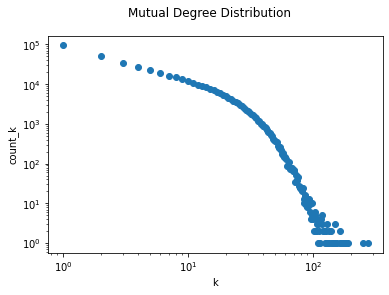

In [6]:
plot_degree_distribution(G)

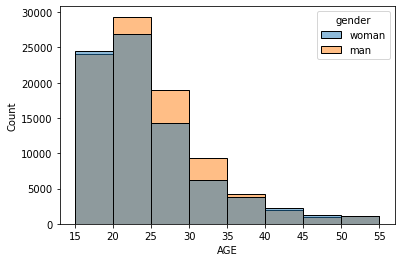

In [7]:
plot_age_distribution_by_gender(nodes)

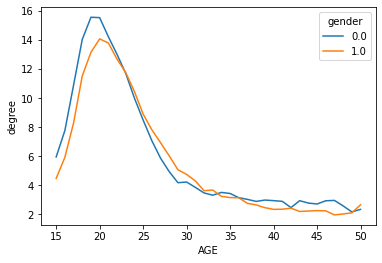

In [8]:
plot_node_degree_by_gender(nodes, G)

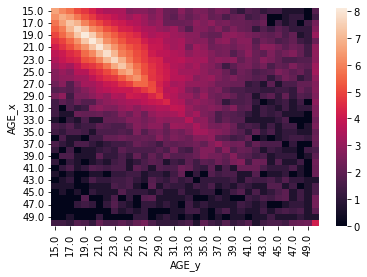

In [9]:
edges_w_features = add_node_features_to_edges(nodes, edges)
plot_age_relations_heatmap(edges_w_features)

In [10]:
def get_nbrs_for_node(node_id, G):
    """Return ids of nbrs of node"""
    return list(dict(G[node_id]).keys())

In [11]:
get_nbrs_for_node(11, G)

[1, 308, 309, 310, 313, 315, 316, 318, 319, 322, 325, 331, 332, 334, 336, 339]

In [12]:
def plot_age_distribution_by_gender(nodes):
    """Plot a histogram where the color represents gender"""
    plot_df = nodes[["AGE", "gender"]].copy(deep=True).astype(float)
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.histplot(data=plot_df, x="AGE", hue="gender", bins=np.arange(0, 45, 5) + 15)

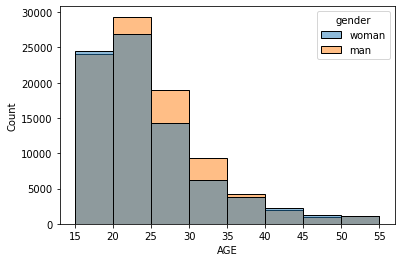

In [13]:
plot_age_distribution_by_gender(nodes)

# PLOTS

In [14]:
def plot_node_degree_by_gender(nodes, G):
    """Plot the average of node degree across age and gender"""
    # TODO: this could be generalized for different node level statistics as well!
    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    #adding title, and rename the legends
    sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender",  ci=None, palette=['b', 'r'], linewidth=2.5).set_title('Degree centrality')
    plt.legend(title='Gender', loc='upper right', labels=['male', 'female'])

#### Degree centrality plotting

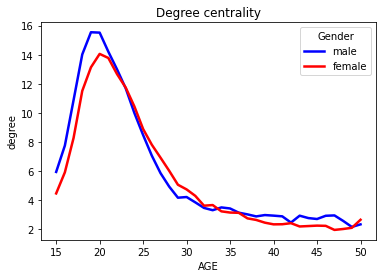

In [15]:
plot_node_degree_by_gender(nodes, G)

Látható a diagramon, hogy a fiatal férifaknak átlagosan több barátjuk van a Pokec-en, a fiatal nőkhöz képest. Azonban amint elkezd csökkenni a barátok száma (a középkorúaknak egyre kevesebb az átlagos fokszámuk), a nemek közötti különbség eltűnik, mondhatni kisimul 35 éves korig. Utána ismét látható kis növekedés a különbségben a férfiak részére kb 48 éves korig. A "Inferring User Demographics and Social Strategies in Mobile Social Networks" cikkhez hasonló mintázat figyelhető meg abban a tekintetben, hogy a 20-as évek elején járóknak van átlagosan a legmagasabb fokszámuk (itt legtöbb ismerősük), és utána folyamatosan csökken az átlagos fokszám.

In [16]:
nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
        )

In [17]:
#hozzáadjuk a dataframe-hez a szomszédai átlagos fokszámát
nodes_w_degree2 = nodes_w_degree
nodes_w_degree2["nb_conn"] = nx.average_neighbor_degree(G).values()
nodes_w_degree2["cc"] = nx.clustering(G).values()

In [18]:
type(nodes_w_degree2)

pandas.core.frame.DataFrame

#### Neighbor Connectivity plotting

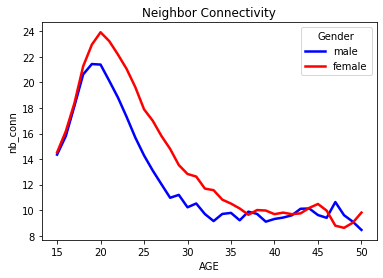

In [19]:
sns.lineplot(data=nodes_w_degree2, x="AGE", y="nb_conn", hue="gender",  ci=None, palette=['b', 'r'], linewidth=2.5).set_title('Neighbor Connectivity')
plt.legend(title='Gender', loc='upper right', labels=['male', 'female'])


Látható, hogy a szomszédok átlagios fokszáma is folyamatosan csökken az életkor növekedésével. A nők esetében magasabb szintről süllyed lefelé, de 35 éves kor felett már elhanyagolható a különbség

#### Triadic Closure plotting

(0.0, 0.3)

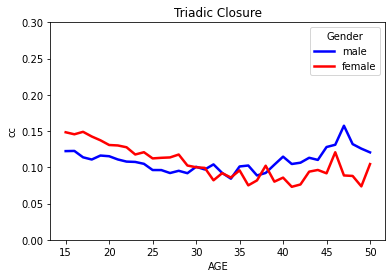

In [20]:
a_plot = sns.lineplot(data=nodes_w_degree2, x="AGE", y="cc", hue="gender", ci=None, palette=['b', 'r'], linewidth=2.5).set_title('Triadic Closure')
plt.legend(title='Gender', loc='upper right', labels=['male', 'female'])
plt.ylim(0, 0.3)

# Strength of social tie

In [21]:
def plot_age_relations_heatmap_ff(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    #only the f-f edges
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [22]:
def plot_age_relations_heatmap_mm(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""

    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    #only the m-m edges
    plot_df_m_m = plot_df.loc[(1, 1)].reset_index()
    plot_df_heatmap = plot_df_m_m.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [23]:
def plot_age_relations_heatmap_fm(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    
    #only the f-m edges
    plot_df_f_m = plot_df.loc[(1, 0)].reset_index()
    plot_df_heatmap = plot_df_f_m.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [24]:
def plot_age_relations_heatmap_all(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    #no selection criteria based on gender
    plot_df_heatmap = plot_df.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

 ### Strength of social tie ALL

XY-axis: age of users with specific gender. 
The spectrum color represents the number of connections

Text(33.0, 0.5, 'Age')

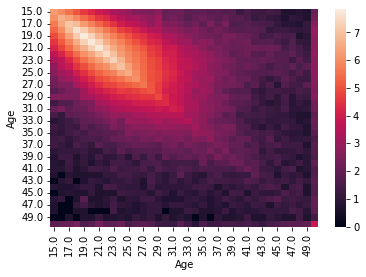

In [25]:
edges_w_features = add_node_features_to_edges(nodes, edges)
plot_age_relations_heatmap_all(edges_w_features)
plt.xlabel("Age")
plt.ylabel("Age")

 ### Strength of social tie F-F

Text(33.0, 0.5, 'Age - F')

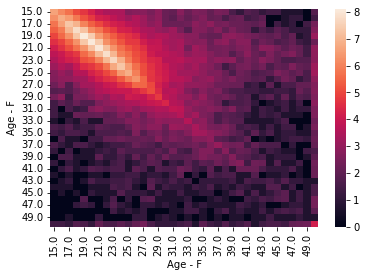

In [26]:
plot_age_relations_heatmap_ff(edges_w_features)
plt.xlabel("Age - F")
plt.ylabel("Age - F")

 ### Strength of social tie M-M

Text(33.0, 0.5, 'Age - M')

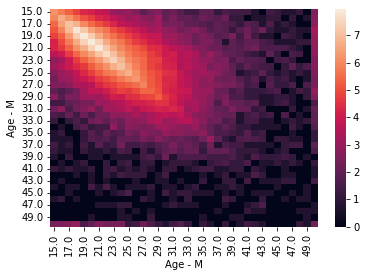

In [27]:
plot_age_relations_heatmap_mm(edges_w_features)
plt.xlabel("Age - M")
plt.ylabel("Age - M")

 ### Strength of social tie F-M

Text(33.0, 0.5, 'Age - M')

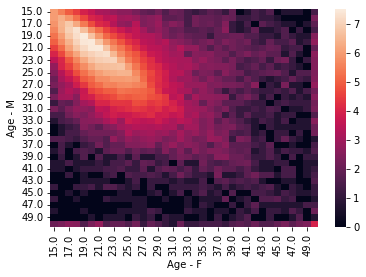

In [28]:
plot_age_relations_heatmap_fm(edges_w_features)
plt.xlabel("Age - F")
plt.ylabel("Age - M")

## without logging

In [29]:
def plot_age_relations_heatmap_all_no_log(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    #no selection criteria based on gender
    plot_df_heatmap = plot_df.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    sns.heatmap(plot_df_heatmap)

Text(33.0, 0.5, 'Age')

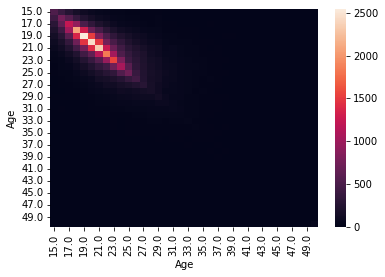

In [30]:
plot_age_relations_heatmap_all_no_log(edges_w_features)
plt.xlabel("Age")
plt.ylabel("Age")

Amennyiben nem logolunk, úgy csak a nagyon nagy kontrasztokat fogjuk látni, azt, hogy az átlóban fiatalkorban nagyon nagyszámú kapcsolat van a saját korosztállyal, azonban más információt nem tudunk leolvasni csak azt, hogy ehhez képest relatíve minden más korosztálynak minden korosztállyal kevés a kapcsolata

# Estimation of gender on the test set

In [31]:
#ez a nagy adatbazis
nodes_w_degree2

,public,gender,region,AGE,TRAIN_TEST,0,nb_conn,cc
user_id,,,,,,,,
1,1,NaN,"zilinsky kraj, zilina",NaN,TEST,6,13.500000,0.000000
4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN,1,6.000000,0.000000
17,1,NaN,"zilinsky kraj, martin",NaN,TEST,4,11.000000,0.166667
5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN,7,12.285714,0.190476
18,1,NaN,"zilinsky kraj, kysucke nove mesto",NaN,TEST,13,24.230769,0.192308
...,...,...,...,...,...,...,...,...
1632779,1,NaN,"trenciansky kraj, myjava",NaN,TEST,1,1.000000,0.000000
1632782,1,NaN,"bratislavsky kraj, bratislava - nove mesto",NaN,TEST,1,2.000000,0.000000
1632783,1,NaN,"trenciansky kraj, povazska bystrica",NaN,TEST,1,1.000000,0.000000


In [32]:
#levalasztjuk a test adatokat es a train adatokat
testdf = nodes_w_degree2.loc[nodes_w_degree2['TRAIN_TEST'] == 'TEST']
traindf = nodes_w_degree2.loc[nodes_w_degree2['TRAIN_TEST'] == 'TRAIN']

In [33]:
#levagjuk ami nem kell
testdf = testdf.drop(testdf.columns[5], axis = 1)
testdf = testdf.drop(['public', 'region', 'nb_conn', 'cc' ], axis=1)
traindf = traindf.drop(traindf.columns[5], axis = 1)
traindf = traindf.drop(['public', 'region', 'nb_conn', 'cc' ], axis=1)

In [34]:
#melyik nemből van több a train adatbézisban (az lesz egyenlőség esetén a predikció)
traindf['gender'].value_counts()

1.0    89930
0.0    80449
Name: gender, dtype: int64

In [35]:
#csinalunk egy predikciokat tartlmazo df-et is
preddf = testdf.drop(['gender', 'AGE', 'TRAIN_TEST'], axis = 1)
preddf['gender'] = 0

In [36]:
traindf

,gender,AGE,TRAIN_TEST
user_id,,,
4,0.0,26.0,TRAIN
5,1.0,26.0,TRAIN
31,1.0,24.0,TRAIN
7,0.0,22.0,TRAIN
10,0.0,22.0,TRAIN
...,...,...,...
1632664,0.0,28.0,TRAIN
1632683,1.0,43.0,TRAIN
1632724,1.0,34.0,TRAIN


In [37]:
#Andras fuggvenye, ami listaba szedi az ismerosoket
def get_nbrs_for_node(node_id, G):
    """Return ids of nbrs of node"""
    return list(dict(G[node_id]).keys())

In [38]:
#nézzünk egy példát : 80-as id-val rendelkező illető a testdf-ből, meghatérozzuk a szomszédait, listába tesszük őket
nlist = get_nbrs_for_node(80, G)
#ez alapján leszűrjük a traindf-et a szomszédaira
ndf  = traindf[traindf.index.isin(nlist)]
#baratok szama
friends = ndf['gender'].count()
#fiu baratok szama
mfriends = ndf['gender'].sum()
#amennyiben a baratai fele vagy annal tobb a fiu, akkor azt mondjuk hogy fiu, egyebkent marad a 0 (vagyis lany)
if friends/2 <= mfriends:
    preddf.gender[80] = 1

In [39]:
#most mehet iteralva
#1. kik vannak a test set-ben (indexek)
test_indexes = testdf.index.tolist()
#2. loop
for index in tqdm(test_indexes):
    nlist = get_nbrs_for_node(index, G)
    ndf  = traindf[traindf.index.isin(nlist)]
    friends = ndf['gender'].count()
    mfriends = ndf['gender'].sum()
    
    if friends/2 <= mfriends:
        preddf.gender[index] = 1

100%|█████████████████████████████████████████████████████████████████████████| 264211/264211 [11:39<00:00, 377.55it/s]


In [40]:
preddf

,gender
user_id,
1,0
17,1
18,1
19,0
32,1
...,...
1632779,1
1632782,1
1632783,1
